# Abstract

In this project, we attempted to predict the state of a 2D Ising model using fully a 2D convolutional neural network (CNN). Ising models are models of ferromagnetic systems that exist in 2 main phase: below the critical temperature and above the critical temperature. Systems which exists below the critical temperature ($T_c$ = 2.2692 K here) tend to have spins aligned whereas spins of systems at higher temperatures have no mean distribution which form distinct images. CNNs are popularly used to classify such images (like digit classification) which is what we treat the lattice as. Following a typical CNN structure and finetuning certain hyperparameters, our model yields an accuracy of 0.901.

# Physical System and Model

The 2D Ising model is a simple model of a ferromaganetic material with a phase transition (1). It is a square lattice of dimensions LxL. At each point in the lattice, there are spins which can exist as $s_i \in$ {-1, 1}. The total energy of the system is expressed as:

\begin{equation}
    E(\{s_i\}) = -\sum_{\langle i,j \rangle}s_i s_j - H\sum_i s_i
\end{equation}

where $\{s_i\}$ is the entire configuration of the spins, H is the external magnetic field, and ${\langle i,j \rangle}$ denotes summation over the nearest pairs in cardinal directions (Top, bottom, left, right) (1). This equation is normalized with J, the coupling constant which is determined by the strength of spin-spin interactions. At a given temperature T, the equilibrium probablity density is the Boltzmann distribution (1):

\begin{equation}
    p(\{s_i\}) = Z^{-1} exp(-E(\{s_i\})/T)
\end{equation}

where Z is the partition function of the system.

For the systems we will consider, there is no external magnetic field. As a result, H = 0. There exists a critical temperature $T_c$ which is calculated as follows:

\begin{equation}
    T_c = \frac{2}{log(1+\sqrt{2})} = 2.2692 K
\end{equation}

Below $T_c$, the spins tend to be aligned in the same direction giving rise to the clumps of spins. Above this temperature, there is no mean orientation for the spins at H = 0 (1). This is related to the entropy of the systems at various temperatures. At lower temparatures, the system poessesses a lower entropy and the spins tend to be aligned. This correpsonds to a coupling constant of J > 0 and such lattices are said to be ferromagnetic. Conversely, at higher temperatures there is a higher entropy and the spins tend to be randomly oriented. As a result, J < 0 and such materials exhibit antiferromagnetic behavior. The critical temperature serves as the point at which systems become spontaneously magnetized which is reflected in the orientation of the spins in a single direction (2). The data we provide our convolutional neural network reflects all these patterns and we want the machine learning model to pick up on this pattern.

# Algorithms

The aim of this project was to determine the phase of a given 2D Ising model. We have classified the 2 phases which the model can exist at into 2 categories: (1) below the critical temperature, and (2) above the critical temperature. Machine learning (ML) models can handle these problems quite well, being frequently employed to classify various images through the usage of 2D convolutional neural networks.

For this project, we trained a 2D CNN (convolutional neural network). CNNs typically use the following architecture:

![Image](https://drive.google.com/uc?export=view&id=1oMb_-v1VAFpfq6mno391Ip1ZK80eLx2B)

There are 4 main layers used in CNNs (3):

1. Convolutional Layers: This consists of an NxN filter which slides over the entire image. It transforms those part of the images through a mathematical operation called a convolution which produces a scalar value. The result is a matrix of nxn scalars where n < N.
2. Pooling Layers: In this project we used max pooling. From the convolutional layers, it picks out the maximum value from each feature map produced by the filters. This is a form of sampling which reduces computation and guards against overfitting.
3. ReLU Layer: Known as the Rectified Linear Unit, this helps ignore negative values by choosing max(0, x). This is especially useful in our Ising models to highlight clusters with spin +1.
4. Fully-Connected Layers: The high-level reasoning occurs here. They compose of neurons which depend on weights, biases, and activation functions.

Machine learning models employ iterative methods, which means they adjust the weights and biases over a number of iterations. To determine how this will occur, they use a loss function which indicates how far off the machine learning results are from the true values they want to fit. This model was developed in TensorFlow and Keras which also provide a range of optimizers for us to use. They use a learning rate and performance metrics to update the weights and biases at each step. In this project, we used the `adam` optimizer, the MSE (Mean Squared Error) loss function, and the accuracy performance metric.

In machine learning models, there are certain system parameters that have to be optimized externally. These include the number of neurons in the dense layer, the number of epochs for which our system is trained, the choice of activation functions used in each hidden layer, etc. Such parameters are referred to as hyperparameters and fine tuning them can significantly improve the performance of a model. To optimize our hyperparameters, we used `GridSearchCV` from `scikit-learn` which is a popular method.

Based on this background information on CNNs and Keras, a brief outline of the algorithm for classifying the phases of 2D Ising models is provided below:

1. Generate lattice data of shape 32x32 using Markov Chain Monte-Carlos method. Lattice configurations are flattened into arrays of length 1024.
2. Read in data. Extract features and targets. Further split them into training, testing, and validation sets.
3. Construct CNN.
4. Train on training data with validation data for comparison.
5. Run on testing data and calculate accuracy.
6. Fine tune hyperparameters and train optimized model
7. Present results of optimized model.

The features of input data are N lattices as 1D arrays of length 1024 (Nx1024) while the targets (phases) are of the shape Nx1. To reconstruct them as square lattices, each array of length 1024 is reshaped into a 2D array of dimensions 32x32 which preserves the original information. Through the convolutional layers, they are processed into smaller 2D arrays and are eventually flatted into 1D arrays. This is fed through a dense layers in a fully connected neural network which gives a singular output 0 or 1. 0 corresponds to the temperature of the system being below $T_c$ while 1 corresponds to the temperature of the system being above $T_c$.

# Code

In [ ]:
!pip install -U keras-tuner
!pip install scikeras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras_tuner.tuners import BayesianOptimization
from scikeras.wrappers import KerasClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


## 1. Load and Prepare Data

In [ ]:
ising_dataset = pd.read_csv('/content/drive/MyDrive/ising_dataset.csv')

In [ ]:
# Select features and target
ising_features = ising_dataset.iloc[:, 2:-3]  # Lattice points
ising_target = ising_dataset.iloc[:, -1]  # Phase

In [ ]:
# Create training, testing, and validation split
X_train, X_test_all, y_train, y_test_all = model_selection.train_test_split(ising_features, ising_target, test_size=0.5)
X_test, X_validate, y_test, y_validate = model_selection.train_test_split(X_test_all, y_test_all, test_size=1/3)

In [ ]:
X_training = np.zeros((len(X_train), 32, 32, 1))
X_testing = np.zeros((len(X_test), 32, 32, 1))
X_validating = np.zeros((len(X_validate), 32, 32, 1))

for i in range(len(X_train)):
    config = X_train.iloc[i]
    config = np.asarray(config)
    config = config.reshape((32,32,1))
    X_training[i] = config

for i in range(len(X_test)):
    config = X_test.iloc[i]
    config = np.asarray(config)
    config = config.reshape((32,32,1))
    X_testing[i] = config

for i in range(len(X_validate)):
    config = X_validate.iloc[i]
    config = np.asarray(config)
    config = config.reshape((32,32,1))
    X_validating[i] = config

X_train = X_training
X_test = X_testing
X_validate = X_validating

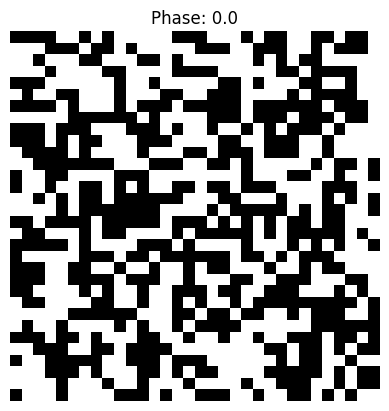

In [ ]:
# Visualize a lattice configuration
img = X_train[0]
show_phase = y_train.iloc[0]
img = np.asarray(img)
plt.imshow(img, cmap='gray')

plt.xlabel('x axis')
plt.ylabel('y axis')
plt.title(f'Phase: {show_phase}')
plt.axis('off')
plt.show()

## 2. Build Model

In [ ]:
# Function to create CNN model
def create_CNN(cnn1_dropout=0.2, dense_neurons=256, dense_activation='relu'):

    L = 32 # Length of square lattice

    # Construct sequential model
    model = Sequential()

    # Input Layer
    model.add(Conv2D(filters=8, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(L,L,1)))

    # Pooling Layer
    model.add(MaxPool2D(pool_size=(2,2)))

    # Dropout Layer
    model.add(Dropout(cnn1_dropout))

    # Convolutional Layer
    model.add(Conv2D(filters=16, kernel_size=(3,3),padding='Same', activation='relu'))

    # Pooling Layer
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    # Dropout Layer
    model.add(Dropout(0.23))

    # Flatten layer to form fully connected neural network
    model.add(Flatten())

    # Dense layer
    model.add(Dense(dense_neurons, activation=dense_activation))

    # Dropout Layer
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

    return model

## 3. Train Model

In [ ]:
training_spin_configs = X_train
training_spin_phases = y_train

test_spin_configs = X_test
test_spin_phases = y_test

In [ ]:
# Train model
model = create_CNN()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 8)           │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,033 (1.01 MB)

 Trainable params: 264,033 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train model
history = model.fit(training_spin_configs, training_spin_phases, epochs=100, batch_size=50, validation_data=(X_validate, y_validate))

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - acc: 0.5348 - loss: 0.2914 - val_acc: 0.5500 - val_loss: 0.2465
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - acc: 0.5610 - loss: 0.2467 - val_acc: 0.5460 - val_loss: 0.2470
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - acc: 0.5966 - loss: 0.2418 - val_acc: 0.5580 - val_loss: 0.2328
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - acc: 0.6395 - loss: 0.2248 - val_acc: 0.6600 - val_loss: 0.2040
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - acc: 0.7204 - loss: 0.1922 - val_acc: 0.7100 - val_loss: 0.1745
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - acc: 0.7840 - loss: 0.1525 - val_acc: 0.8360 - val_loss: 0.1334
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - acc: 0.7843 - loss: 0.1491 - val_acc: 0.8500 - val_loss: 0.1290
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - acc: 0.8610 - loss: 0.1105 - val_acc: 0.7980 - val_loss: 0.1360
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/ste

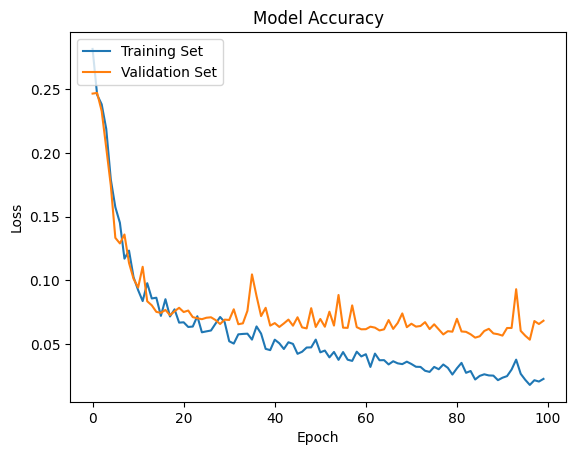

In [ ]:
# Visualize model training history
plt.plot(history.history['loss'], label='Training Set')
plt.plot(history.history['val_loss'], label='Validation Set')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Accuracy')
plt.legend(loc='upper left')
plt.show()

## 4. Test Model

In [ ]:
# Generate predictions from test data
prediction = model.predict(test_spin_configs)

for row_index, row in enumerate(prediction):
    for col_index, value in enumerate(prediction):
      if value <= 0.5: prediction[col_index] = 0
      else: prediction[col_index] = 1
#print(prediction)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [ ]:
# Evaluate accuracy
acc_score = accuracy_score(y_test, prediction)
print('Accuracy Score:', acc_score)

Accuracy Score: 0.886


## 5. Fine Tune Hyperparameters

In [ ]:
"""
# Hyperparameters we will optimize:
1. Number of epochs
2. Batch size
3. Number of neurons in dense hidden layer
"""

# Create dictionary of hyperparameters we want to optimize
epochs = [50, 100]
batch_size = [50, 100]
dense_neurons = [192, 256, 320]

param_grid = dict(epochs=epochs, batch_size=batch_size, dense_neurons=dense_neurons)

In [ ]:
optim_model = KerasClassifier(build_fn=create_CNN, dense_neurons=None, verbose=0)
grid = GridSearchCV(estimator=optim_model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(

## 6. Present Optimal Model

In [ ]:
# Print best parameter set
print('Best Accuracy: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

# Print accuracy of all parameter sets
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

print('\nAll Results:')
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

Best Accuracy: 0.901000 using {'batch_size': 100, 'dense_neurons': 320, 'epochs': 50}

All Results:
0.847000 (0.049051) with: {'batch_size': 50, 'dense_neurons': 192, 'epochs': 50}
0.880000 (0.013038) with: {'batch_size': 50, 'dense_neurons': 192, 'epochs': 100}
0.843000 (0.030594) with: {'batch_size': 50, 'dense_neurons': 256, 'epochs': 50}
0.894000 (0.033076) with: {'batch_size': 50, 'dense_neurons': 256, 'epochs': 100}
0.891000 (0.021071) with: {'batch_size': 50, 'dense_neurons': 320, 'epochs': 50}
0.885000 (0.014142) with: {'batch_size': 50, 'dense_neurons': 320, 'epochs': 100}
0.845000 (0.033317) with: {'batch_size': 100, 'dense_neurons': 192, 'epochs': 50}
0.875000 (0.040497) with: {'batch_size': 100, 'dense_neurons': 192, 'epochs': 100}
0.861000 (0.048415) with: {'batch_size': 100, 'dense_neurons': 256, 'epochs': 50}
0.888000 (0.023791) with: {'batch_size': 100, 'dense_neurons': 256, 'epochs': 100}
0.901000 (0.023324) with: {'batch_size': 100, 'dense_neurons': 320, 'epochs': 50}

# Results

The output from the algorithm for a given configuration is a single value: 0 or 1. To determine how well it performs on test data, it is fed test data configurations and compares the output with the corresponding true values. The percentage of correct values is calculated using the accuracy metric.

The initital model yields an accuracy of 0.886 which indicate the CNN works reasonably well. Next, we adjust the hyperparameters to find the best combination of machine learning parameters that produce the highest accuracy. As seen in section 7 of the code, the set of hyperparameters `{batch_size': 100, 'dense_neurons': 320, 'epochs': 50}` yields the highest accuracy of 0.901. It also has the lowest corresponding loss at 0.023324. This means that for approximately 90% of the test cases, the CNN with the above set of hyperparameters correctly predicts the phase of the Ising model.

# References

1. R.Roy, Physics 170N Project 3 Slides (May 2024)
2. Magnetism: The Ising model. Available at: http://web.mit.edu/ceder/publications/Ising%20Model.pdf (Accessed: 12 June 2024).
3. Comprehensive Guide to CNN with Keras. Available at: https://www.kaggle.com/code/prashant111/comprehensive-guide-to-cnn-with-keras (Accessed: 12 June 2024).
4. Use Keras Deep Learning Models with Scikit-Learn in Python. Available at: https://machinelearningmastery.comuse-keras-deep-learning-models-scikit-learn-python/ (Accessed: 12 June 2024).